In [1]:
import os
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
from utils import data_handler
from utils.models import vanilla_autoencoder

In [2]:
%load_ext tensorboard
!rm -rf ../workfiles/logs/


In [3]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session


<module 'utils.data_handler' from '/Users/aygalic/Library/CloudStorage/OneDrive-Personal/polimi/Thesis/genome_analysis_parkinson/src/utils/data_handler.py'>

In [4]:
import sklearn
sklearn.__version__

'1.0.2'

In [5]:
#x_train, filenames = data_handler.generate_dataset(feature_selection_threshold = 5, retain_phases="2", return_filenames= True, batch_size = 128)


x_train, filenames = data_handler.generate_dataset(feature_selection_threshold = 5, 
                                                   feature_selection_proceedure = 0, 
                                                   retain_phases="2", 
                                                   return_filenames= True, 
                                                   subsample = 500)

retained phase 2
loading samples...
loaded 499 samples
standardisation for LASSO regression...
Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


In [6]:
latent_dim = 64
t_shape = (6161)


autoencoder = vanilla_autoencoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [6]:
checkpoint_filepath = '../workfiles/simple_autoencoer_model/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=15, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=30)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [7]:
%tensorboard --logdir ../workfiles/logs/fit


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

In [7]:
hist = autoencoder.fit(x_train, epochs=1000, callbacks=cb)

Epoch 1/1000


2023-07-19 10:53:10.006048: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


23/23 [==============================] - 3s 76ms/step - loss: 1265952.1979 - lr: 0.0010
Epoch 2/1000
23/23 [==============================] - 2s 72ms/step - loss: 182503.7559 - lr: 0.0010
Epoch 3/1000
23/23 [==============================] - 2s 73ms/step - loss: 91259.9313 - lr: 0.0010
Epoch 4/1000
23/23 [==============================] - 2s 86ms/step - loss: 65841.6475 - lr: 0.0010
Epoch 5/1000
23/23 [==============================] - 2s 71ms/step - loss: 52495.6284 - lr: 0.0010
Epoch 6/1000
23/23 [==============================] - 2s 75ms/step - loss: 50615.4720 - lr: 0.0010
Epoch 7/1000
23/23 [==============================] - 2s 84ms/step - loss: 46059.9113 - lr: 0.0010
Epoch 8/1000
23/23 [==============================] - 2s 82ms/step - loss: 41953.9294 - lr: 0.0010
Epoch 9/1000
23/23 [==============================] - 2s 76ms/step - loss: 31841.3114 - lr: 0.0010
Epoch 10/1000
23/23 [==============================] - 2s 85ms/step - loss: 29709.4912 - lr: 0.0010
Epoch 11/1000
23/23

In [15]:
autoencoder.load_weights(checkpoint_filepath)


[837113.875, 143241.328125, 89924.15625, 64741.53125, 50368.62890625, 47664.859375, 44028.984375, 37332.27734375, 30193.84765625, 27366.40234375, 26136.8359375, 25047.236328125, 23833.52734375, 20520.24609375, 18128.34765625, 17614.8984375, 17825.140625, 17668.626953125, 16899.81640625, 15490.2548828125, 15079.7978515625, 14461.986328125, 13582.783203125, 13220.1533203125, 12704.7138671875, 13096.5185546875, 12761.154296875, 14386.2216796875, 13401.78515625, 12190.55078125, 10563.236328125, 9571.658203125, 9244.3857421875, 8945.9560546875, 10039.8623046875, 9365.548828125, 9604.1083984375, 8504.861328125, 8385.4033203125, 8843.9560546875, 9150.771484375, 8879.755859375, 8466.48828125, 9575.822265625, 8944.2802734375, 8122.04541015625, 8409.826171875, 7369.904296875, 7646.3818359375, 7372.63671875, 7943.060546875, 8078.76220703125, 8043.2236328125, 8239.3427734375, 8708.244140625, 7764.88525390625, 6871.306640625, 6844.60693359375, 7449.21533203125, 7381.5712890625, 7195.75244140625, 73

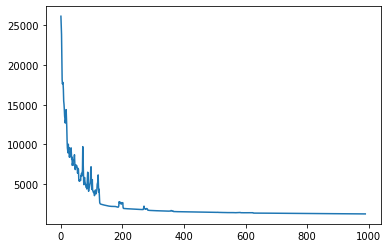

In [11]:
plt.plot(hist.history['loss'][10:])
print(hist.history['loss'])




### some diagnosis

In [16]:
e = iter(x_train).next()
z = autoencoder.encoder(e)
z

<tf.Tensor: shape=(128, 64), dtype=float32, numpy=
array([[-3995.9197 ,  1321.9951 ,   256.24255, ...,  1044.189  ,
         -441.1704 , -2202.7556 ],
       [-5332.4727 , -1338.6959 ,   991.2119 , ...,  1749.8998 ,
          250.48059,  1277.4714 ],
       [-3602.0642 ,  1200.7404 ,  2332.909  , ...,  1097.5797 ,
          864.3883 ,  -357.71484],
       ...,
       [-1985.9099 ,  -337.5752 ,  2209.9553 , ...,   138.2388 ,
        -1856.2509 ,   753.416  ],
       [-3821.562  , -2220.589  ,  2685.5806 , ...,  1622.9342 ,
        -1497.7108 ,    41.12083],
       [-4110.1987 ,  1688.3682 ,  1523.4669 , ...,  2129.2903 ,
        -1748.9088 ,  -496.9225 ]], dtype=float32)>

In [17]:
print(autoencoder.decoder(z))
print(e)

tf.Tensor(
[[-22.259817   48.19281    26.67791   ... -17.582493  -95.53001
   15.623904 ]
 [-34.149155   57.257698   30.225393  ...  27.359684   38.676056
   53.58772  ]
 [  7.4029617  51.95375    50.81598   ...  55.40015    -7.9356794
  107.63385  ]
 ...
 [154.17142    64.13527    70.53975   ... 218.38463    34.539185
  365.56604  ]
 [ 22.40841    44.8817     38.85166   ... 134.4049    254.24692
  127.21396  ]
 [292.7624     72.20849    48.028973  ... 184.1659    334.65073
  137.29916  ]], shape=(128, 6161), dtype=float32)
tf.Tensor(
[[ 28.0786  48.2889  31.8768 ...  21.601   14.5302  43.2891]
 [ 34.8483  55.0274  36.8456 ...  28.7308  33.4212  42.899 ]
 [ 31.6444  57.4141  41.5785 ...  37.2859  22.7498  95.4406]
 ...
 [ 95.63    59.8847  68.3827 ... 271.181   61.4339 390.335 ]
 [ 57.8501  45.1154  33.3128 ...  36.8473  14.2945  61.5693]
 [156.021   65.4736  41.3597 ... 169.735  283.042  202.926 ]], shape=(128, 6161), dtype=float32)


In [18]:
autoencoder.encoder.save('../workfiles/simple_autoencoer_model')


INFO:tensorflow:Assets written to: ../workfiles/simple_autoencoer_model/assets


In [19]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

23/23 [==============================] - 0s 5ms/step


In [20]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [21]:
df.to_csv("../workfiles/compressed_data_simple_autoencoder_phase_2.csv")
